## imports

In [1]:
import os
import regex as re
import glob
import unicodedata
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import json # For tokenizer files and potentially configs

In [2]:
# Optional dependencies
try:
    from langdetect import detect, LangDetectException, DetectorFactory
    DetectorFactory.seed = 0  # for reproducible results
    LANGDETECT_AVAILABLE = True
except ImportError:
    LANGDETECT_AVAILABLE = False
    print("Warning: langdetect library not found. French detection step will be unavailable.")

try:
    import arabic_reshaper
    from bidi.algorithm import get_display
    RTL_DISPLAY_AVAILABLE = True
except ImportError:
    RTL_DISPLAY_AVAILABLE = False
    print("Warning: arabic_reshaper or python-bidi not found. RTL text in plots may not render correctly.")


## read files

In [3]:
def read_corpus_files(directory_path: str) -> str:
    """Reads all .txt files from a directory and concatenates their content."""
    all_text = [] # Use a list for efficiency, then join
    file_paths = glob.glob(os.path.join(directory_path, "*.txt"))

    if not file_paths:
        # Return empty string instead of raising ValueError, pipeline can handle it
        print(f"Warning: No .txt files found in {directory_path}")
        return ""

    print(f"Found {len(file_paths)} text files in '{directory_path}'.")
    for file_path in tqdm(file_paths, desc="Reading files"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                all_text.append(f.read())
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    return "\n".join(all_text)

## clean

In [4]:
def clean_text_initial(text: str) -> str:
    """Performs initial cleaning of the text."""
    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    # Remove file markup like [[File:…]]
    text = re.sub(r'\[\[File:[^\]]*\]\]', ' ', text)
    # Remove other generic wiki-like markups (e.g., [[...]], but not [[word]])
    # This regex looks for markups with colons or pipes, common in metadata
    text = re.sub(r'\[\[(?:[^\]]*:|[^\]]*\|[^\]]*)\]\]', ' ', text)
    # Remove simple [[markup]] if it's not just a word
    text = re.sub(r'\[\[([^\]]{20,})\]\]', ' ', text) # Example: if content is too long
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove script-mismatches (e.g., "100px")
    text = re.sub(r'\b\d+px\b', ' ', text)
    # Normalize Unicode to NFKC form for consistency
    text = unicodedata.normalize('NFKC', text)
    # Normalize whitespace early
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## detect french

In [5]:
def detect_and_filter_french_lines(
    lines: list[str],
    french_removal_threshold: float = 0.85, # If >85% of words are French-like
    min_words_for_check: int = 4
    ) -> list[str]:
    """
    Detects and filters out lines that are predominantly French.
    Keeps lines with mixed content or primarily Arabizi/Darija.
    """
    if not LANGDETECT_AVAILABLE:
        print("Skipping French detection: langdetect library not available.")
        return lines

    kept_lines = []
    removed_count = 0
    print(f"Analyzing {len(lines)} lines for French content...")

    for line in tqdm(lines, desc="Filtering French lines"):
        if not line.strip():
            kept_lines.append(line)
            continue

        words = line.split()
        if len(words) < min_words_for_check:
            kept_lines.append(line) # Keep short lines, likely not full French sentences
            continue

        try:
            # Use langdetect on the line
            lang = detect(line)
            if lang == 'fr':
                # Further heuristic: check proportion of purely Latin words
                # (without Arabizi numbers like 2,3,5,7,9)
                latin_word_count = 0
                arabizi_signal_present = False
                for word in words:
                    if re.search(r'[a-zA-Z]', word) and not re.search(r'[0-9]', word): # Simple check for Latin word
                        latin_word_count += 1
                    if re.search(r'[23579]', word): # Arabizi digits
                        arabizi_signal_present = True
                
                # If it's detected as French AND has many Latin words AND no strong Arabizi digit signal,
                # it's more likely to be "pure" French.
                # This is a heuristic. A simpler rule is just if lang == 'fr'.
                # For now, let's use a simpler rule: if langdetect says 'fr', it's likely French.
                # Darija with many French words might be misclassified, but the goal is to remove "pure French".
                
                # If the line is detected as French and does not seem to contain Arabizi markers (like 3, 7 etc.)
                # it's a stronger candidate for removal.
                # A simple approach: if langdetect says 'fr', remove.
                # If it contains Arabizi markers like '3', '7', it's likely Darija.
                if not any(c in line for c in "23579"): # if no common Arabizi numbers
                    removed_count += 1
                else: # It's 'fr' but has Arabizi numbers, likely Darija
                    kept_lines.append(line)
            else:
                # If not 'fr' (e.g., 'ar', 'en' for Arabizi, etc.), keep it.
                kept_lines.append(line)
        except LangDetectException:
            # If language cannot be detected (e.g., too short, mixed symbols), keep it by default
            kept_lines.append(line)
            
    print(f"Removed {removed_count} lines identified as predominantly French.")
    return kept_lines

## char map

In [6]:
ARABIZI_TO_ARABIC_MAP = {
    # Digits (ensure these are processed before any general digit removal)
    '2': 'ء', '3': 'ع', '4': 'غ', '6': 'ط', '8': 'ق', # Added some other common ones
    '7': 'ح', '5': 'خ', '9': 'ق', # 9 can be ق or ص, user asked for ق, but ص is also common. Let's use ق as requested.
                                # The user's original request had '9' -> 'ق'. I'll stick to that. '5' -> 'خ'
    # Common multi-character sequences (longest first for correct replacement)
    'ch': 'ش', 'sh': 'ش', 'kh': 'خ', 'gh': 'غ',
    'th': 'ث', 'dh': 'ذ', 'ou': 'و', 'oo': 'و',
    # Single letters (ensure input text is lowercased before this)
    'a': 'ا', 'b': 'ب', 'c': 'س', # 'c' can be tricky, 'س' is a common default
    'd': 'د', 'e': 'ي', # 'e' often like 'i' or kasra, 'ي' is a placeholder. Can also be 'ا'.
    'f': 'ف', 'g': 'ڭ', # Moroccan Gaf. normalize_arabic can convert ڭ to ك or ج later if needed.
    'h': 'ه', 'i': 'ي', 'j': 'ج', 'k': 'ك', 'l': 'ل', 'm': 'م',
    'n': 'ن', 'o': 'و', 'p': 'ب', # 'پ' is not standard, so 'ب'
    'q': 'ق', 'r': 'ر', 's': 'س',
    't': 'ت', 'u': 'و', 'v': 'ف', # 'ڤ' is not standard, so 'ف'
    'w': 'و', 'x': 'كس', 'y': 'ي', 'z': 'ز',
}
# # Add user's specific request for 9->ق
# ARABIZI_TO_ARABIC_MAP['9'] = 'ق'

## arabize

In [7]:
def arabize_text(text: str) -> str:
    """Converts Arabizi (Latin script Darija with numbers) to Arabic script."""
    text = text.lower() # Important for consistent mapping

    # Create a list of keys sorted by length (descending) to handle multi-char keys first
    sorted_keys = sorted(ARABIZI_TO_ARABIC_MAP.keys(), key=len, reverse=True)

    for key in sorted_keys:
        text = text.replace(key, ARABIZI_TO_ARABIC_MAP[key])
    
    # Specific case for 'g', if it was mapped to 'ڭ' and needs to be 'غ' or 'ج'
    # For now, 'ڭ' is kept, and normalize_arabic can handle it.
    # If user specifically wants 'g' -> 'غ', then ARABIZI_TO_ARABIC_MAP['g'] = 'غ'

    return text

## normalize

In [8]:
def normalize_arabic_text(text: str) -> str:
    """Normalizes Arabic script."""
    # Remove diacritics (tashkeel)
    text = re.sub(r'[\u064B-\u065F\u0670]', '', text)
    # Remove tatweel (ـ)
    text = text.replace('\u0640', '')
    
    # Normalize Alef forms to plain Alef (ا)
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا').replace('ٱ', 'ا')
    
    # Normalize common variants
    text = text.replace('ة', 'ه')  # Ta marbuta to Ha
    text = text.replace('ى', 'ي')  # Alef maksura to Ya
    
    # Normalize Perso-Arabic letters to common Arabic equivalents if desired
    text = text.replace('گ', 'ك')  # Persian Gaf to Kaf
    text = text.replace('ڭ', 'ك')  # Moroccan Gaf (if produced by arabize_text) to Kaf. Or map to ج or غ if preferred.
                                  # Let's map ڭ to ك as it's a common normalization.
    text = text.replace('چ', 'ش')  # Cheh to Shin (if 'ch' was mapped to 'چ')
    text = text.replace('پ', 'ب')  # Peh to Ba
    text = text.replace('ڤ', 'ف')  # Veh to Fa
        
    return text

## clean 2

In [9]:
def clean_text_final(text: str, remove_all_numbers: bool = True) -> str:
    """Performs final cleaning, focusing on script and remaining numbers."""
    if remove_all_numbers:
        # Remove standalone numbers (Western or Arabic-Indic if any were produced)
        text = re.sub(r'\b\d+\b', ' ', text) # Western digits
        text = re.sub(r'\b[\u0660-\u0669]+\b', ' ', text) # Arabic-Indic digits
        text = re.sub(r'\(\d+\)', ' ', text)
        text = re.sub(r'\([\u0660-\u0669]+\)', ' ', text)

    # Keep only Arabic letters and whitespace.
    # This assumes all desired text is now in Arabic script.
    text = re.sub(r'[^\p{Arabic}\s]', ' ', text, flags=re.UNICODE)
    
    # Normalize whitespace again
    text = re.sub(r'\s+', ' ', text).strip()
    return text

## filter short

In [10]:
def filter_short_tokens_from_lines(
    lines: list[str],
    min_token_length: int,
    short_token_allowlist: set = None
    ) -> tuple[list[str], int, int]:
    """
    Filters out tokens shorter than min_token_length from each line,
    unless they are in the allowlist.
    Returns filtered lines and token counts.
    """
    if short_token_allowlist is None:
        short_token_allowlist = set()

    filtered_lines = []
    original_token_count = 0
    final_token_count = 0

    print(f"Filtering tokens shorter than {min_token_length} characters (allowlist: {short_token_allowlist})...")
    for line in tqdm(lines, desc="Filtering short tokens"):
        tokens = line.split()
        original_token_count += len(tokens)
        
        kept_tokens = [
            token for token in tokens
            if len(token) >= min_token_length or token in short_token_allowlist
        ]
        
        final_token_count += len(kept_tokens)
        if kept_tokens: # Only add line if it's not empty after filtering
            filtered_lines.append(" ".join(kept_tokens))
    
    print(f"Original token count (whitespace split): {original_token_count}")
    print(f"Token count after filtering short tokens: {final_token_count}")
    filtered_out_count = original_token_count - final_token_count
    print(f"Filtered out {filtered_out_count} short tokens.")
    
    if not filtered_lines and original_token_count > 0 :
         print("WARNING: All lines became empty after filtering short tokens. Check min_token_length or corpus.")
    return filtered_lines, original_token_count, final_token_count

## train bpe

In [11]:
def train_bpe_tokenizer(
    lines_for_bpe: list[str],
    vocab_size: int,
    min_frequency: int,
    bpe_tokenizer_output_file: str,
    temp_bpe_train_file: str
    ) -> Tokenizer:
    """Trains a BPE tokenizer on the provided lines of text."""
    print(f"Training BPE tokenizer (Vocab Size: {vocab_size}, Min Freq: {min_frequency})...")
    
    with open(temp_bpe_train_file, 'w', encoding='utf-8') as f:
        for line in tqdm(lines_for_bpe, desc="Writing lines for BPE training"):
            f.write(line + '\n')

    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace() # Respect existing word boundaries initially
    trainer = BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=min_frequency,
        special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
    )
    
    tokenizer.train([temp_bpe_train_file], trainer)
    tokenizer.save(bpe_tokenizer_output_file)
    print(f"BPE Tokenizer trained and saved to {bpe_tokenizer_output_file}")
    
    if os.path.exists(temp_bpe_train_file):
        os.remove(temp_bpe_train_file)
    
    return tokenizer

## apply bpe

In [12]:
def apply_bpe_and_save_corpus(
    lines_to_tokenize: list[str],
    tokenizer_path: str, # Path to the saved tokenizer.json
    final_tokenized_output_file: str
    ) -> int:
    """Applies a trained BPE tokenizer to lines and saves the tokenized corpus."""
    print(f"Applying BPE tokenizer from {tokenizer_path}...")
    tokenizer = Tokenizer.from_file(tokenizer_path)
    total_bpe_tokens = 0

    with open(final_tokenized_output_file, 'w', encoding='utf-8') as f_out:
        for line in tqdm(lines_to_tokenize, desc="Tokenizing with BPE"):
            if not line.strip():
                continue
            encoding = tokenizer.encode(line)
            bpe_tokens = encoding.tokens
            f_out.write(" ".join(bpe_tokens) + '\n')
            total_bpe_tokens += len(bpe_tokens)
            
    print(f"Finished BPE tokenizing. Saved {total_bpe_tokens} BPE tokens to {final_tokenized_output_file}")
    return total_bpe_tokens

## analyze

In [13]:
def analyze_token_corpus(
    token_source: str | list[str], # Can be file path or list of tokens
    top_n: int = 30,
    is_bpe_corpus: bool = False
    ) -> pd.DataFrame | None:
    """Analyzes token frequencies and lengths from a file or list of tokens."""
    all_tokens = []
    if isinstance(token_source, str): # It's a file path
        print(f"Reading tokens from {token_source} for analysis...")
        try:
            with open(token_source, 'r', encoding='utf-8') as f_in:
                for line in tqdm(f_in, desc="Reading tokens for analysis"):
                    all_tokens.extend(line.strip().split())
        except FileNotFoundError:
            print(f"Error: Could not find {token_source} for analysis.")
            return None
    elif isinstance(token_source, list):
        all_tokens = token_source
    else:
        print("Error: token_source must be a file path or a list of tokens.")
        return None

    if not all_tokens:
        print("Warning: No tokens provided or found for analysis.")
        return None

    corpus_type = "BPE Token" if is_bpe_corpus else "Word Token"
    print(f"Analyzing {len(all_tokens)} {corpus_type.lower()}s...")

    token_freq = {}
    for token in tqdm(all_tokens, desc="Calculating Frequencies"):
        token_freq[token] = token_freq.get(token, 0) + 1

    df = pd.DataFrame.from_dict(token_freq, orient='index', columns=['frequency'])
    df = df.sort_values('frequency', ascending=False).reset_index()
    df.columns = ['token', 'frequency']
    df['length'] = df['token'].apply(len)
    total_token_occurrences = df['frequency'].sum() # Sum of frequencies is total tokens
    df['rel_frequency'] = df['frequency'] / total_token_occurrences

    print("Generating plots...")
    plt.style.use('seaborn-v0_8-whitegrid') # Example style

    # Plot top token frequencies
    plt.figure(figsize=(14, 8))
    plot_data = df.head(top_n).copy()
    plot_data['token_str'] = plot_data['token'].astype(str) # Ensure string type

    # Handle RTL display for Arabic tokens
    if RTL_DISPLAY_AVAILABLE and plot_data['token_str'].apply(lambda x: bool(re.search(r'[\u0600-\u06FF]', x))).any():
        plot_data['token_display'] = plot_data['token_str'].apply(
            lambda x: get_display(arabic_reshaper.reshape(x))
        )
        sns.barplot(x='token_display', y='frequency', data=plot_data, palette="viridis")
    else:
        sns.barplot(x='token_str', y='frequency', data=plot_data, palette="viridis")
    
    plt.title(f'Top {top_n} {corpus_type} Frequencies', fontsize=16)
    plt.xlabel(corpus_type, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=60, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot token length distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['length'], bins=max(1, df['length'].max()), kde=False, color="skyblue")
    plt.title(f'{corpus_type} Length Distribution', fontsize=16)
    plt.xlabel(f'{corpus_type} Length', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # common_max_len = df['length'].quantile(0.99)
    # plt.xlim(0, min(common_max_len + 1, df['length'].max() + 1)) # Adjust x-limit
    plt.tight_layout()
    plt.show()

    print(f"\nTop {top_n} {corpus_type}s (from analysis):")
    print(df[['token', 'frequency']].head(top_n).to_string())
    print("Analysis complete.")
    return df

## pipeline

In [14]:
def darija_preprocessing_pipeline(
    corpus_dir: str,
    output_dir: str = "processed_darija_corpus",
    sample_size_chars: int | None = None, # Max characters to process from raw text
    
    # Step controls
    do_initial_clean: bool = True,
    do_filter_french: bool = True,
    do_arabize: bool = True,
    do_normalize_arabic: bool = True,
    do_final_clean: bool = True,
    do_filter_short_tokens: bool = True,
    do_bpe_tokenize: bool = True,
    do_analyze_final_corpus: bool = True,

    # Configuration for steps
    french_filter_config: dict | None = None,
    short_token_filter_config: dict | None = None,
    bpe_config: dict | None = None,
    analysis_config: dict | None = None
    ):
    """
    Main pipeline for preprocessing Darija corpus.
    Allows enabling/disabling and configuring each step.
    """
    os.makedirs(output_dir, exist_ok=True)
    print(f"Pipeline started. Output will be in '{output_dir}'")

    # --- Default configurations ---
    _french_filter_config = {'french_removal_threshold': 0.85, 'min_words_for_check': 4}
    if french_filter_config: _french_filter_config.update(french_filter_config)

    _short_token_filter_config = {'min_token_length': 2, 'allowlist': {'و', 'في', 'من', 'الى', 'لا', 'ما', 'عن', 'مع'}} # Arabic allowlist
    if short_token_filter_config: _short_token_filter_config.update(short_token_filter_config)
    
    _bpe_config = {'vocab_size': 30000, 'min_frequency': 2}
    if bpe_config: _bpe_config.update(bpe_config)

    _analysis_config = {'top_n': 30}
    if analysis_config: _analysis_config.update(analysis_config)

    # --- File paths ---
    temp_bpe_train_file = os.path.join(output_dir, "temp_corpus_for_bpe_training.txt")
    bpe_tokenizer_file = os.path.join(output_dir, "darija_bpe_tokenizer.json")
    
    if do_bpe_tokenize:
        final_corpus_path = os.path.join(output_dir, "darija_bpe_tokenized_for_w2v.txt")
    else:
        final_corpus_path = os.path.join(output_dir, "darija_processed_words_for_w2v.txt")

    # === PIPELINE STEPS ===

    # 1. Read Corpus
    print("\n--- Step 1: Reading Corpus ---")
    raw_text = read_corpus_files(corpus_dir)
    if not raw_text:
        print("No text read from corpus. Exiting pipeline.")
        return None, None
    
    if sample_size_chars and len(raw_text) > sample_size_chars:
        print(f"Sampling {sample_size_chars} characters from the corpus.")
        raw_text = raw_text[:sample_size_chars]
    print(f"Initial corpus size: {len(raw_text)} characters.")

    processed_text = raw_text

    # 2. Initial Cleaning
    if do_initial_clean:
        print("\n--- Step 2: Initial Text Cleaning ---")
        processed_text = clean_text_initial(processed_text)
        print(f"Text size after initial cleaning: {len(processed_text)} characters.")

    # Convert text to lines for line-based processing
    current_lines = processed_text.splitlines()
    current_lines = [line for line in current_lines if line.strip()] # Remove empty lines

    # 3. Filter French Lines
    if do_filter_french:
        print("\n--- Step 3: Filtering French Lines ---")
        if not LANGDETECT_AVAILABLE:
            print("Skipping French filtering as langdetect is not available.")
        else:
            current_lines = detect_and_filter_french_lines(
                current_lines,
                **_french_filter_config
            )
            print(f"{len(current_lines)} lines remaining after French filtering.")

    # Join lines back to text for text-based processing
    processed_text = "\n".join(current_lines)

    # 4. Arabize Text (Latin/Arabizi to Arabic script)
    if do_arabize:
        print("\n--- Step 4: Arabizing Text ---")
        processed_text = arabize_text(processed_text)
        print(f"Text size after arabization: {len(processed_text)} characters.")
        # print("Sample after arabization:", processed_text[:500])


    # 5. Normalize Arabic Script
    if do_normalize_arabic:
        print("\n--- Step 5: Normalizing Arabic Script ---")
        processed_text = normalize_arabic_text(processed_text)
        print(f"Text size after Arabic normalization: {len(processed_text)} characters.")
        # print("Sample after Arabic normalization:", processed_text[:500])

    # 6. Final Cleaning (remove remaining non-Arabic, numbers if configured)
    if do_final_clean:
        print("\n--- Step 6: Final Text Cleaning ---")
        processed_text = clean_text_final(processed_text, remove_all_numbers=True)
        print(f"Text size after final cleaning: {len(processed_text)} characters.")
        # print("Sample after final cleaning:", processed_text[:500])

    # Convert text back to lines for token-based filtering and BPE
    current_lines = processed_text.splitlines()
    current_lines = [line for line in current_lines if line.strip()]

    # 7. Filter Short Tokens
    if do_filter_short_tokens:
        print("\n--- Step 7: Filtering Short Tokens ---")
        current_lines, _, _ = filter_short_tokens_from_lines(
            current_lines,
            min_token_length=_short_token_filter_config['min_token_length'],
            short_token_allowlist=_short_token_filter_config['allowlist']
        )
        print(f"{len(current_lines)} lines remaining after short token filtering.")
        if not current_lines and processed_text: # Check if all content was filtered
             print("Warning: No lines remaining after short token filtering. Check configuration or corpus state.")
             # Decide if to stop or continue with empty lines for BPE (which will likely fail or be empty)
             # For now, we'll let it proceed, BPE training will handle empty input.

    # 8. BPE Tokenization (Train and Apply) OR Save Word-Tokenized Corpus
    if do_bpe_tokenize:
        print("\n--- Step 8: BPE Tokenization ---")
        if not current_lines:
            print("No lines available for BPE training. Skipping BPE.")
            final_corpus_path = None # Indicate no BPE corpus generated
            # Optionally, save an empty file or the word-tokenized (empty) version
            with open(os.path.join(output_dir, "darija_processed_words_empty.txt"), 'w') as f:
                f.write("") # Create an empty file
        else:
            trained_tokenizer = train_bpe_tokenizer(
                current_lines,
                vocab_size=_bpe_config['vocab_size'],
                min_frequency=_bpe_config['min_frequency'],
                bpe_tokenizer_output_file=bpe_tokenizer_file,
                temp_bpe_train_file=temp_bpe_train_file
            )
            _ = apply_bpe_and_save_corpus(
                current_lines,
                bpe_tokenizer_file,
                final_corpus_path
            )
    else:
        print("\n--- Step 8: Saving Word-Tokenized Corpus (BPE Skipped) ---")
        if not current_lines:
            print("No lines available to save for word-tokenized corpus.")
            with open(final_corpus_path, 'w', encoding='utf-8') as f:
                f.write("") # Save an empty file
            print(f"Saved empty word-tokenized corpus to {final_corpus_path}")
        else:
            word_count = 0
            with open(final_corpus_path, 'w', encoding='utf-8') as f:
                for line in tqdm(current_lines, desc="Saving word-tokenized corpus"):
                    f.write(line + '\n')
                    word_count += len(line.split())
            print(f"Saved {word_count} words in {len(current_lines)} lines to {final_corpus_path}")

    # 9. Analyze Final Corpus
    if do_analyze_final_corpus and final_corpus_path and os.path.exists(final_corpus_path) and os.path.getsize(final_corpus_path) > 0:
        print("\n--- Step 9: Analyzing Final Corpus ---")
        analyze_token_corpus(
            final_corpus_path,
            top_n=_analysis_config['top_n'],
            is_bpe_corpus=do_bpe_tokenize # True if BPE was done
        )
    elif do_analyze_final_corpus:
        print("\n--- Step 9: Analyzing Final Corpus ---")
        print("Skipping analysis: final corpus file is empty or does not exist.")


    print("\n--- Pipeline Finished ---")
    return final_corpus_path, bpe_tokenizer_file if do_bpe_tokenize else None

## main

Pipeline started. Output will be in 'processed_darija_v2'

--- Step 1: Reading Corpus ---
Found 23 text files in 'data'.


Reading files: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]


Sampling 10000000 characters from the corpus.
Initial corpus size: 10000000 characters.

--- Step 2: Initial Text Cleaning ---
Text size after initial cleaning: 9945835 characters.

--- Step 3: Filtering French Lines ---
Analyzing 1 lines for French content...


Filtering French lines: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Removed 0 lines identified as predominantly French.
1 lines remaining after French filtering.

--- Step 4: Arabizing Text ---
Text size after arabization: 9804240 characters.

--- Step 5: Normalizing Arabic Script ---
Text size after Arabic normalization: 9770366 characters.

--- Step 6: Final Text Cleaning ---
Text size after final cleaning: 9489368 characters.

--- Step 7: Filtering Short Tokens ---
Filtering tokens shorter than 2 characters (allowlist: {'لا', 'يا', 'هو', 'و', 'في', 'ما', 'به', 'من', 'له'})...


Filtering short tokens: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Original token count (whitespace split): 1773520
Token count after filtering short tokens: 1715696
Filtered out 57824 short tokens.
1 lines remaining after short token filtering.

--- Step 8: BPE Tokenization ---
Training BPE tokenizer (Vocab Size: 25000, Min Freq: 3)...


Writing lines for BPE training: 100%|██████████| 1/1 [00:00<00:00, 14.04it/s]





BPE Tokenizer trained and saved to processed_darija_v2/darija_bpe_tokenizer.json
Applying BPE tokenizer from processed_darija_v2/darija_bpe_tokenizer.json...


Tokenizing with BPE: 100%|██████████| 1/1 [00:09<00:00,  9.64s/it]


Finished BPE tokenizing. Saved 2167536 BPE tokens to processed_darija_v2/darija_bpe_tokenized_for_w2v.txt

--- Step 9: Analyzing Final Corpus ---
Reading tokens from processed_darija_v2/darija_bpe_tokenized_for_w2v.txt for analysis...


Reading tokens for analysis: 1it [00:00,  3.27it/s]


Analyzing 2167536 bpe tokens...


Calculating Frequencies: 100%|██████████| 2167536/2167536 [00:00<00:00, 2421858.95it/s]
/tmp/ipykernel_11402/130974114.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='token_display', y='frequency', data=plot_data, palette="viridis")


Generating plots...


/tmp/ipykernel_11402/130974114.py:63: UserWarning: Glyph 65261 (\N{ARABIC LETTER WAW ISOLATED FORM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11402/130974114.py:63: UserWarning: Glyph 65266 (\N{ARABIC LETTER YEH FINAL FORM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11402/130974114.py:63: UserWarning: Glyph 65247 (\N{ARABIC LETTER LAM INITIAL FORM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11402/130974114.py:63: UserWarning: Glyph 65254 (\N{ARABIC LETTER NOON FINAL FORM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11402/130974114.py:63: UserWarning: Glyph 65251 (\N{ARABIC LETTER MEEM INITIAL FORM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11402/130974114.py:63: UserWarning: Glyph 65275 (\N{ARABIC LIGATURE LAM WITH ALEF ISOLATED FORM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_11402/130974114.py:63: UserWarning: Glyph 65166 (\N{ARABIC LETTER ALEF FINAL FORM}) m

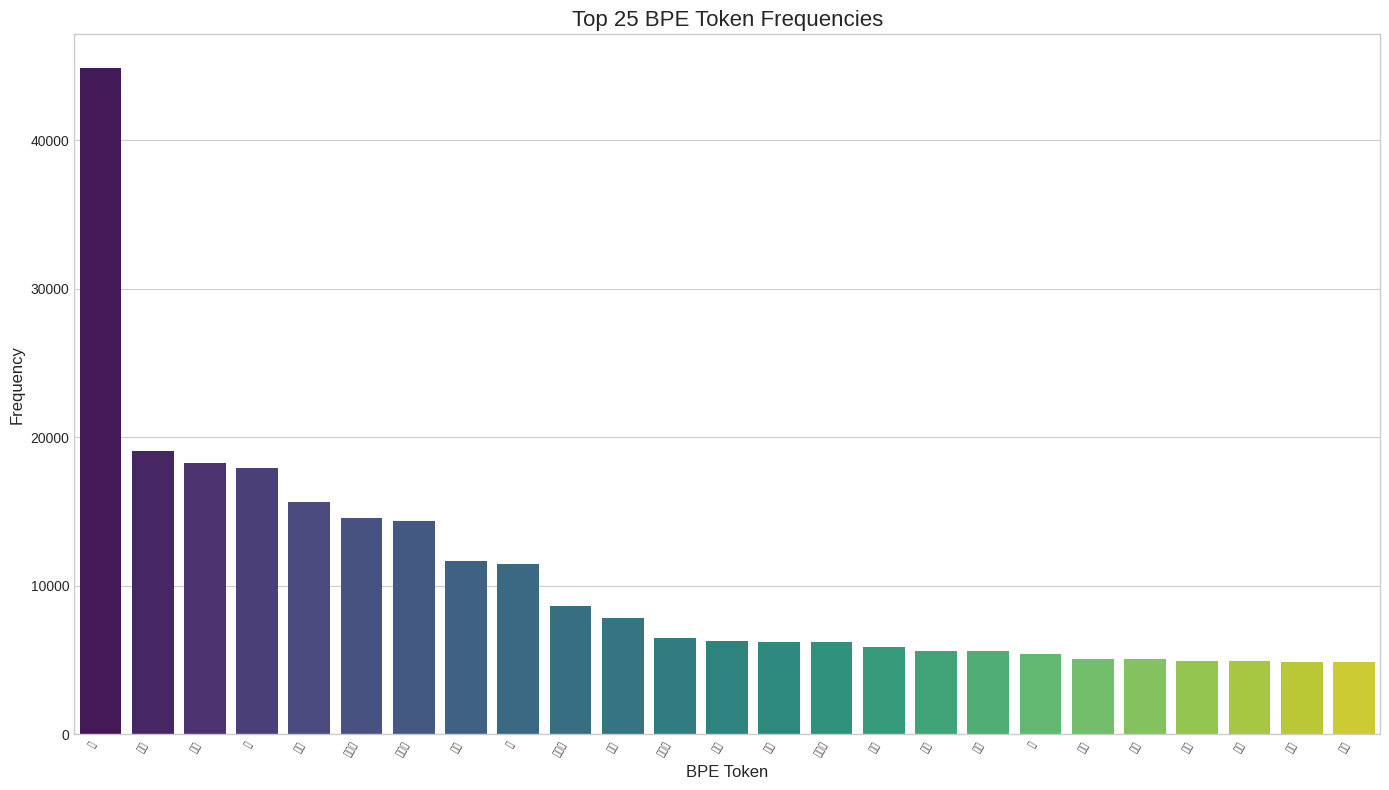

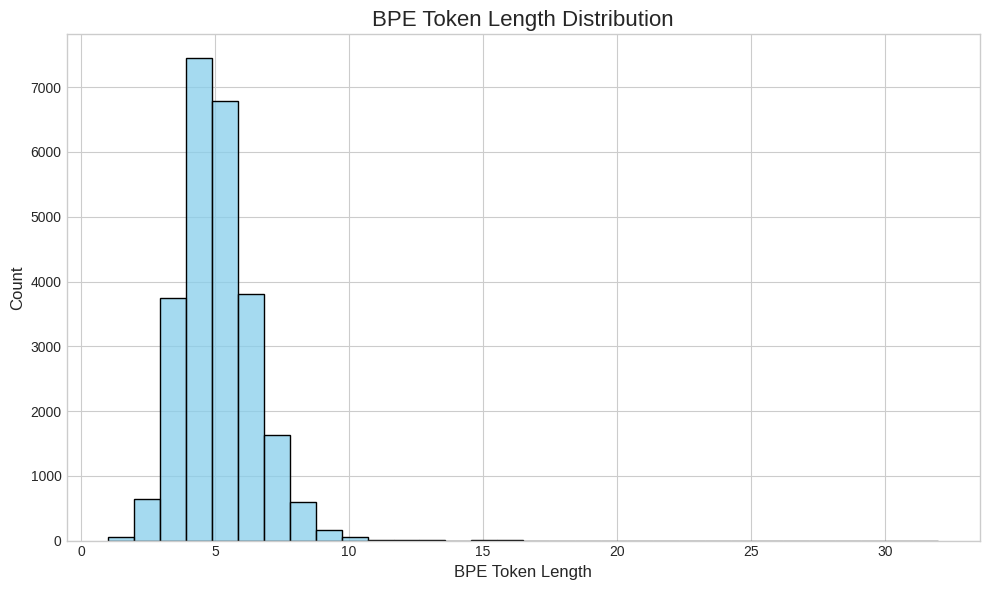


Top 25 BPE Tokens (from analysis):
   token  frequency
0      و      44871
1     لي      19081
2     من      18289
3     لا      17955
4     ما      15619
5    علي      14560
6    انا      14344
7     في      11637
8   الله      11467
9    غير       8607
10    شي       7849
11   حتي       6451
12    ها       6277
13    كي       6225
14   كان       6217
15    يا       5847
16    وا       5610
17    ان       5587
18     ش       5383
19   ولا       5061
20    تي       5053
21    دي       4949
22    را       4912
23    مي       4873
24    هو       4871
Analysis complete.

--- Pipeline Finished ---

Preprocessing complete.
Final tokenized corpus for Word2Vec: processed_darija_v2/darija_bpe_tokenized_for_w2v.txt
BPE tokenizer model saved to: processed_darija_v2/darija_bpe_tokenizer.json


In [15]:
# Example usage (in a separate script or IPython/Jupyter notebook)
# from darija_processor import darija_preprocessing_pipeline # If saved as darija_processor.py

if __name__ == "__main__":
    CORPUS_DIRECTORY = 'data' # Change to your corpus directory path
    OUTPUT_DIRECTORY = 'processed_darija_v2'
    
    # Example: Run with most steps enabled
    final_file, tokenizer_model = darija_preprocessing_pipeline(
        corpus_dir=CORPUS_DIRECTORY,
        output_dir=OUTPUT_DIRECTORY,
        sample_size_chars=10000000, # Process first 10 million characters, or None for full
        
        do_initial_clean=True,
        do_filter_french=True, # Requires langdetect
        do_arabize=True,
        do_normalize_arabic=True,
        do_final_clean=True,
        do_filter_short_tokens=True,
        do_bpe_tokenize=True, # Set to False to get word tokens instead of BPE
        do_analyze_final_corpus=True,

        # --- You can customize configurations here ---
        # french_filter_config={'min_words_for_check': 3},
        short_token_filter_config={
            'min_token_length': 2, # Keep words of length 2 or more
             'allowlist': {'و', 'في', 'من', 'لا', 'ما', 'يا', 'له', 'به', 'هو'} # Common short Arabic words
        },
        bpe_config={'vocab_size': 25000, 'min_frequency': 3},
        analysis_config={'top_n': 25}
    )

    if final_file:
        print(f"\nPreprocessing complete.")
        print(f"Final tokenized corpus for Word2Vec: {final_file}")
        if tokenizer_model:
            print(f"BPE tokenizer model saved to: {tokenizer_model}")
    else:
        print("\nPreprocessing did not produce a final corpus file.")

    # Example: Run without BPE, keeping only words of length 3+
    # final_file_no_bpe, _ = darija_preprocessing_pipeline(
    #     corpus_dir=CORPUS_DIRECTORY,
    #     output_dir=os.path.join(OUTPUT_DIRECTORY, "no_bpe_run"),
    #     sample_size_chars=1000000,
    #     do_bpe_tokenize=False,
    #     short_token_filter_config={'min_token_length': 3, 'allowlist': set()}
    # )
    # if final_file_no_bpe:
    #     print(f"\nProcessed (no BPE) corpus: {final_file_no_bpe}")